In [10]:
%pip install "numpy<2.0.0"

Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install --upgrade "numpy<2.0.0"

  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
devito 4.8.19 requires numpy<2.3.1,>=2, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
#from anytree import Node, RenderTree
from typing import Dict, List
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F
from utils import calculate_mape, calculate_score
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import KFold
#from utils import *
from utils import create_submission

In [3]:
folders = [
    '../data/speed-and-structure-train-data/*',
    '../data/speed-and-structure-train-data-extended-part1/*',
    '../data/speed-and-structure-train-data-extended-part2/*'
]

In [5]:
sample_paths = []
for folder in folders:
    sample_paths.extend(glob(folder))

print(f"Total samples found: {len(sample_paths)}")

Total samples found: 4999


# Creating a Pytorch Dataset

In [8]:
class SeismicInversionDataset(Dataset):
    def __init__(self, sample_paths, downsample_factor=3):
        self.sample_paths = sample_paths
        self.downsample_factor = downsample_factor

    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        sample_path = self.sample_paths[idx]
        
        # Load and stack the 5 receiver data files
        input_stack = []
        for i in [1, 75, 150, 225, 300]:
            file_path = os.path.join(sample_path, f"receiver_data_src_{i}.npy")
            data = np.load(file_path).astype(np.float32)  # shape: (10001, 31)
            data = data[::self.downsample_factor]         # downsample time axis, e.g., to ~250
            input_stack.append(data)

        input_tensor = np.stack(input_stack, axis=0)  # shape: (5, T, 31)
        input_tensor = torch.from_numpy(input_tensor)

        # Load target velocity model
        target_path = os.path.join(sample_path, "vp_model.npy")
        target = np.load(target_path).astype(np.float32)  # shape: (300, 1259)
        target_tensor = torch.from_numpy(target).unsqueeze(0)  # shape: (1, 300, 1259)

        return input_tensor, target_tensor

In [10]:
dataset = SeismicInversionDataset(sample_paths)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for x, y in loader:
    print("Input:", x.shape)    
    print("Target:", y.shape)   
    break

Input: torch.Size([4, 5, 3334, 31])
Target: torch.Size([4, 1, 300, 1259])


# Visualizing a sample

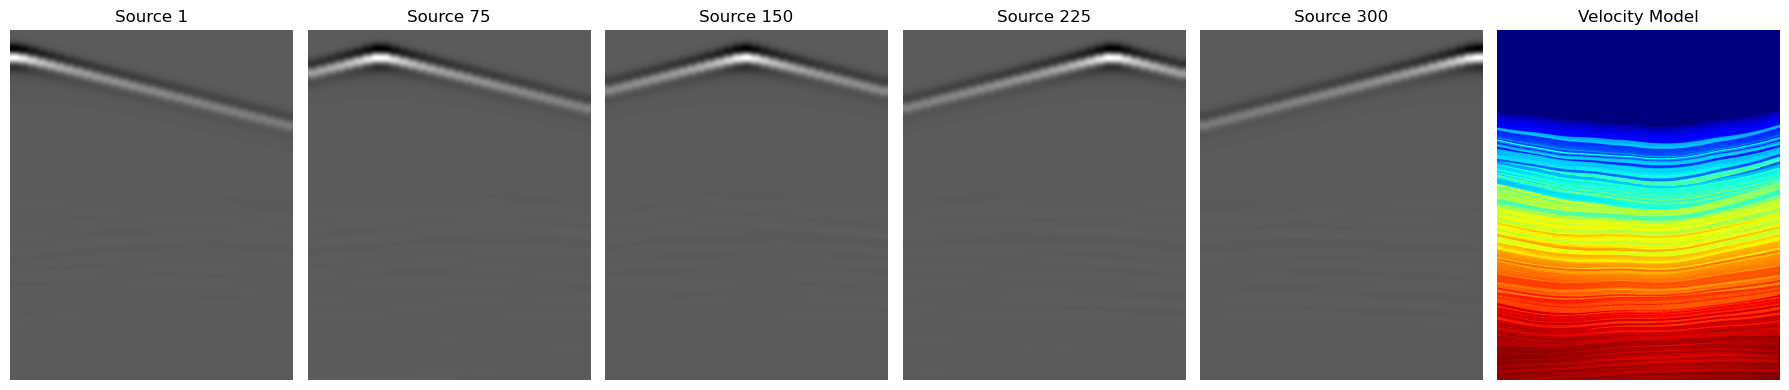

In [13]:
sample_path = sample_paths[0]
source_coordinates = [1, 75, 150, 225, 300]

# Create a 1x6 subplot: 5 for receiver data, 1 for velocity model
f, ax = plt.subplots(1, 6, figsize=(18, 4))

# Plot receiver data for each source
for i, s in enumerate(source_coordinates):
    rec_data = np.load(os.path.join(sample_path, f"receiver_data_src_{s}.npy"))
    ax[i].imshow(rec_data, cmap="gray", aspect="auto")
    ax[i].set_title(f"Source {s}")
    ax[i].axis("off")

# Plot the velocity model (transpose for correct orientation)
target_data = np.load(os.path.join(sample_path, "vp_model.npy"))
ax[5].imshow(target_data.T, cmap="jet", aspect="auto")
ax[5].set_title("Velocity Model")
ax[5].axis("off")

plt.tight_layout()
plt.show()

# Baseline UNET 

In [19]:
class conv_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c,out_c,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class encoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.conv=conv_block(in_c,out_c)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    def forward(self,x):
        x = self.conv(x)
        p = self.pool(x)
        return x,p

class decoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv=conv_block(in_c,out_c)
    def forward(self,x,skip):
        x = self.up(x)
        #Matching sizes if needed
        if x.shape[2:]!=skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
        x = torch.cat([x,skip],dim=1)
        x = self.conv(x)
        return x
        
        

In [21]:
class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1):
        super().__init__()
        self.e1 = encoder_block(in_channels,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)

        self.b = conv_block(512, 1024)

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        self.outputs = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self,inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

# Training the model

In [30]:
train_dataset = SeismicInversionDataset(sample_paths)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Create model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = UNet(in_channels=5, out_channels=1).to(device)

# Loss and optimizer
loss_func = nn.L1Loss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [88]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader,  desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        #Resize
        outputs = nn.functional.interpolate(outputs, size=(300, 1259), mode="bilinear", align_corners=False)
        loss = loss_func(outputs,targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss/len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "unet_seismic.pth")

Epoch 1/20: 100%|█████████████████████████████| 500/500 [03:57<00:00,  2.10it/s]


Epoch [1/20] - Loss: 1.0965


Epoch 2/20: 100%|█████████████████████████████| 500/500 [04:32<00:00,  1.83it/s]


Epoch [2/20] - Loss: 0.2397


Epoch 3/20: 100%|█████████████████████████████| 500/500 [04:12<00:00,  1.98it/s]


Epoch [3/20] - Loss: 0.1468


Epoch 4/20: 100%|█████████████████████████████| 500/500 [04:09<00:00,  2.00it/s]


Epoch [4/20] - Loss: 0.1370


Epoch 5/20: 100%|█████████████████████████████| 500/500 [04:12<00:00,  1.98it/s]


Epoch [5/20] - Loss: 0.1272


Epoch 6/20: 100%|█████████████████████████████| 500/500 [04:06<00:00,  2.03it/s]


Epoch [6/20] - Loss: 0.1151


Epoch 7/20: 100%|█████████████████████████████| 500/500 [04:00<00:00,  2.08it/s]


Epoch [7/20] - Loss: 0.1104


Epoch 8/20: 100%|█████████████████████████████| 500/500 [04:01<00:00,  2.07it/s]


Epoch [8/20] - Loss: 0.1051


Epoch 9/20: 100%|█████████████████████████████| 500/500 [04:03<00:00,  2.05it/s]


Epoch [9/20] - Loss: 0.1040


Epoch 10/20: 100%|████████████████████████████| 500/500 [04:06<00:00,  2.03it/s]


Epoch [10/20] - Loss: 0.1041


Epoch 11/20: 100%|████████████████████████████| 500/500 [04:04<00:00,  2.05it/s]


Epoch [11/20] - Loss: 0.0989


Epoch 12/20: 100%|████████████████████████████| 500/500 [04:07<00:00,  2.02it/s]


Epoch [12/20] - Loss: 0.0987


Epoch 13/20: 100%|████████████████████████████| 500/500 [04:09<00:00,  2.00it/s]


Epoch [13/20] - Loss: 0.0985


Epoch 14/20: 100%|████████████████████████████| 500/500 [04:10<00:00,  1.99it/s]


Epoch [14/20] - Loss: 0.0960


Epoch 15/20: 100%|████████████████████████████| 500/500 [04:11<00:00,  1.99it/s]


Epoch [15/20] - Loss: 0.0960


Epoch 16/20: 100%|████████████████████████████| 500/500 [04:11<00:00,  1.99it/s]


Epoch [16/20] - Loss: 0.0954


Epoch 17/20: 100%|████████████████████████████| 500/500 [04:12<00:00,  1.98it/s]


Epoch [17/20] - Loss: 0.0950


Epoch 18/20: 100%|████████████████████████████| 500/500 [04:14<00:00,  1.96it/s]


Epoch [18/20] - Loss: 0.0939


Epoch 19/20: 100%|████████████████████████████| 500/500 [04:15<00:00,  1.96it/s]


Epoch [19/20] - Loss: 0.0951


Epoch 20/20: 100%|████████████████████████████| 500/500 [04:15<00:00,  1.95it/s]

Epoch [20/20] - Loss: 0.0949


In [90]:
model.eval()
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        preds = model(x)
        preds = nn.functional.interpolate(preds, size=(300, 1259), mode="bilinear", align_corners=False)

        pred_np = preds[0, 0].cpu().numpy()
        gt_np = y[0, 0].cpu().numpy()

        mape = calculate_mape(gt_np, pred_np)
        print(f"Sample MAPE: {mape:.4f}")
        break

Sample MAPE: 0.0262


# Grid Search CV

In [35]:
learning_rates = [1e-4, 1e-3]
num_epochs = 30
weight_decays = [0.0, 1e-5, 1e-4]
k_folds = 3

all_paths = np.array(sample_paths)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
results = {}

In [28]:
for lr in learning_rates:
    for decay in weight_decays:
        fold_mape_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(all_paths)):
            print(f"\n Trying: LR={lr}, Epochs={num_epochs}, Weight Decay={decay}")
            train_paths = all_paths[train_idx]
            val_paths = all_paths[val_idx]

            train_ds = SeismicInversionDataset(train_paths)
            val_ds = SeismicInversionDataset(val_paths)
            train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=1)

            model = UNet(in_channels=5, out_channels=1).to(device)
            loss_func = nn.L1Loss()  
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

            for epoch in range(num_epochs):
                model.train()
                for inputs, targets in tqdm(train_loader):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    #Resize
                    outputs = nn.functional.interpolate(outputs, size=(300, 1259), mode="bilinear", align_corners=False)
                    loss = loss_func(outputs,targets)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            #validate
            model.eval()
            fold_mape = []
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    pred = model(x)
                    pred = nn.functional.interpolate(pred, size=(300, 1259))
                    mape = calculate_mape(y.cpu().numpy()[0, 0], pred.cpu().numpy()[0, 0])
                    fold_mape.append(mape)
            mean_fold_mape = np.mean(fold_mape)
            print(f" Fold {fold+1} MAPE: {mean_fold_mape:.4f}")
            fold_mape_scores.append(mean_fold_mape)
        avg_mape = np.mean(fold_mape_scores)
        results[(lr, num_epochs, decay)] = avg_mape
        print(f"\n Avg MAPE for LR={lr}, Epochs={num_epochs}, Weight_decay={decay}: {avg_mape:.4f}")
            


 Trying: LR=0.0001, Epochs=30, Weight Decay=0.0


100%|█████████████████████████████████████████| 334/334 [03:35<00:00,  1.55it/s]


 Fold 1 MAPE: 0.0488

 Trying: LR=0.0001, Epochs=30, Weight Decay=0.0


100%|█████████████████████████████████████████| 334/334 [03:09<00:00,  1.76it/s]


 Fold 2 MAPE: 0.0748

 Trying: LR=0.0001, Epochs=30, Weight Decay=0.0


100%|█████████████████████████████████████████| 334/334 [03:02<00:00,  1.83it/s]


 Fold 3 MAPE: 0.0358

 Avg MAPE for LR=0.0001, Epochs=30, Weight_decay=0.0: 0.0531

 Trying: LR=0.0001, Epochs=30, Weight Decay=1e-05


100%|█████████████████████████████████████████| 334/334 [02:57<00:00,  1.88it/s]


 Fold 1 MAPE: 0.0898

 Trying: LR=0.0001, Epochs=30, Weight Decay=1e-05


100%|█████████████████████████████████████████| 334/334 [02:53<00:00,  1.93it/s]


 Fold 2 MAPE: 0.0572

 Trying: LR=0.0001, Epochs=30, Weight Decay=1e-05


100%|█████████████████████████████████████████| 334/334 [03:07<00:00,  1.78it/s]


 Fold 3 MAPE: 0.0963

 Avg MAPE for LR=0.0001, Epochs=30, Weight_decay=1e-05: 0.0811

 Trying: LR=0.0001, Epochs=30, Weight Decay=0.0001


100%|█████████████████████████████████████████| 334/334 [02:53<00:00,  1.93it/s]


 Fold 1 MAPE: 0.0615

 Trying: LR=0.0001, Epochs=30, Weight Decay=0.0001


100%|█████████████████████████████████████████| 334/334 [02:47<00:00,  2.00it/s]


 Fold 2 MAPE: 0.0416

 Trying: LR=0.0001, Epochs=30, Weight Decay=0.0001


100%|█████████████████████████████████████████| 334/334 [02:52<00:00,  1.94it/s]


 Fold 3 MAPE: 0.0849

 Avg MAPE for LR=0.0001, Epochs=30, Weight_decay=0.0001: 0.0627

 Trying: LR=0.001, Epochs=30, Weight Decay=0.0


100%|█████████████████████████████████████████| 334/334 [03:03<00:00,  1.82it/s]


 Fold 1 MAPE: 0.0633

 Trying: LR=0.001, Epochs=30, Weight Decay=0.0


100%|█████████████████████████████████████████| 334/334 [03:05<00:00,  1.80it/s]


 Fold 2 MAPE: 0.0477

 Trying: LR=0.001, Epochs=30, Weight Decay=0.0


100%|█████████████████████████████████████████| 334/334 [02:49<00:00,  1.96it/s]


 Fold 3 MAPE: 0.0875

 Avg MAPE for LR=0.001, Epochs=30, Weight_decay=0.0: 0.0661

 Trying: LR=0.001, Epochs=30, Weight Decay=1e-05


100%|█████████████████████████████████████████| 334/334 [03:02<00:00,  1.83it/s]


 Fold 1 MAPE: 0.1264

 Trying: LR=0.001, Epochs=30, Weight Decay=1e-05


100%|█████████████████████████████████████████| 334/334 [03:00<00:00,  1.85it/s]


 Fold 2 MAPE: 0.0803

 Trying: LR=0.001, Epochs=30, Weight Decay=1e-05


100%|█████████████████████████████████████████| 334/334 [03:00<00:00,  1.85it/s]


 Fold 3 MAPE: 0.1022

 Avg MAPE for LR=0.001, Epochs=30, Weight_decay=1e-05: 0.1030

 Trying: LR=0.001, Epochs=30, Weight Decay=0.0001


100%|█████████████████████████████████████████| 334/334 [03:00<00:00,  1.85it/s]


 Fold 1 MAPE: 0.1135

 Trying: LR=0.001, Epochs=30, Weight Decay=0.0001


100%|█████████████████████████████████████████| 334/334 [02:58<00:00,  1.87it/s]


 Fold 2 MAPE: 0.1471

 Trying: LR=0.001, Epochs=30, Weight Decay=0.0001


100%|█████████████████████████████████████████| 334/334 [02:58<00:00,  1.87it/s]


 Fold 3 MAPE: 0.1250

 Avg MAPE for LR=0.001, Epochs=30, Weight_decay=0.0001: 0.1286


In [32]:
best = sorted(results.items(), key=lambda x: x[1])[0]
print(f"\n Best: LR={best[0][0]}, Epochs={best[0][1]}, WD={best[0][2]} — MAPE={best[1]:.4f}")



 Best: LR=0.0001, Epochs=30, WD=0.0 — MAPE=0.0531


# Training the model on the best hyperparameters

In [37]:
def train_unet_model(model, train_loader, device, num_epochs, lr, save_path):
    loss_func = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            outputs = nn.functional.interpolate(outputs, size=(300, 1259), mode="bilinear", align_corners=False)

            loss = loss_func(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")


In [39]:
train_unet_model(model, train_loader, device, 30, 0.0001, "best_unet.pth")

Epoch 1/30: 100%|█████████████████████████████| 500/500 [01:20<00:00,  6.18it/s]


Epoch [1/30] - Avg Loss: 1.3250


Epoch 2/30: 100%|█████████████████████████████| 500/500 [01:16<00:00,  6.53it/s]


Epoch [2/30] - Avg Loss: 0.3179


Epoch 3/30: 100%|█████████████████████████████| 500/500 [01:35<00:00,  5.26it/s]


Epoch [3/30] - Avg Loss: 0.1491


Epoch 4/30: 100%|█████████████████████████████| 500/500 [01:34<00:00,  5.27it/s]


Epoch [4/30] - Avg Loss: 0.1407


Epoch 5/30: 100%|█████████████████████████████| 500/500 [01:38<00:00,  5.08it/s]


Epoch [5/30] - Avg Loss: 0.1274


Epoch 6/30: 100%|█████████████████████████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch [6/30] - Avg Loss: 0.1168


Epoch 7/30: 100%|█████████████████████████████| 500/500 [01:41<00:00,  4.93it/s]


Epoch [7/30] - Avg Loss: 0.1098


Epoch 8/30: 100%|█████████████████████████████| 500/500 [01:43<00:00,  4.85it/s]


Epoch [8/30] - Avg Loss: 0.1050


Epoch 9/30: 100%|█████████████████████████████| 500/500 [01:41<00:00,  4.91it/s]


Epoch [9/30] - Avg Loss: 0.1022


Epoch 10/30: 100%|████████████████████████████| 500/500 [01:42<00:00,  4.89it/s]


Epoch [10/30] - Avg Loss: 0.1013


Epoch 11/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.69it/s]


Epoch [11/30] - Avg Loss: 0.0995


Epoch 12/30: 100%|████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


Epoch [12/30] - Avg Loss: 0.0976


Epoch 13/30: 100%|████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


Epoch [13/30] - Avg Loss: 0.0980


Epoch 14/30: 100%|████████████████████████████| 500/500 [01:45<00:00,  4.75it/s]


Epoch [14/30] - Avg Loss: 0.0963


Epoch 15/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.70it/s]


Epoch [15/30] - Avg Loss: 0.0947


Epoch 16/30: 100%|████████████████████████████| 500/500 [01:45<00:00,  4.75it/s]


Epoch [16/30] - Avg Loss: 0.0944


Epoch 17/30: 100%|████████████████████████████| 500/500 [01:44<00:00,  4.79it/s]


Epoch [17/30] - Avg Loss: 0.0933


Epoch 18/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.68it/s]


Epoch [18/30] - Avg Loss: 0.0935


Epoch 19/30: 100%|████████████████████████████| 500/500 [01:48<00:00,  4.61it/s]


Epoch [19/30] - Avg Loss: 0.0930


Epoch 20/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.69it/s]


Epoch [20/30] - Avg Loss: 0.0933


Epoch 21/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.71it/s]


Epoch [21/30] - Avg Loss: 0.0921


Epoch 22/30: 100%|████████████████████████████| 500/500 [01:45<00:00,  4.72it/s]


Epoch [22/30] - Avg Loss: 0.0913


Epoch 23/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.71it/s]


Epoch [23/30] - Avg Loss: 0.0911


Epoch 24/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.67it/s]


Epoch [24/30] - Avg Loss: 0.0911


Epoch 25/30: 100%|████████████████████████████| 500/500 [01:46<00:00,  4.70it/s]


Epoch [25/30] - Avg Loss: 0.0909


Epoch 26/30: 100%|████████████████████████████| 500/500 [01:41<00:00,  4.92it/s]


Epoch [26/30] - Avg Loss: 0.0900


Epoch 27/30: 100%|████████████████████████████| 500/500 [01:43<00:00,  4.85it/s]


Epoch [27/30] - Avg Loss: 0.0899


Epoch 28/30: 100%|████████████████████████████| 500/500 [01:42<00:00,  4.87it/s]


Epoch [28/30] - Avg Loss: 0.0902


Epoch 29/30: 100%|████████████████████████████| 500/500 [01:42<00:00,  4.88it/s]


Epoch [29/30] - Avg Loss: 0.0897


Epoch 30/30: 100%|████████████████████████████| 500/500 [01:44<00:00,  4.77it/s]


Epoch [30/30] - Avg Loss: 0.0894
Model saved to best_unet.pth


# Attention Unet

In [152]:
class conv_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c,out_c,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [154]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c,out_c,kernel_size=2,stride=2)
        self.attention = attention_block(F_g=out_c, F_l=out_c, F_int=out_c // 2)
        self.conv = conv_block(in_c, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
        attn = self.attention(g=x, x=skip)
        x = torch.cat([x, attn], dim=1)
        x = self.conv(x)
        return x


In [156]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1):
        super().__init__()
        self.e1 = encoder_block(in_channels, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        self.outputs = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        return self.outputs(d4)

## Training Attention unet

In [186]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AttentionUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [188]:
np.random.shuffle(sample_paths)
val_split = 0.2
val_size = int(len(sample_paths) * val_split)
val_paths = sample_paths[:val_size]
train_paths = sample_paths[val_size:]

train_loader = DataLoader(SeismicInversionDataset(train_paths), batch_size=8, shuffle=True)
val_loader = DataLoader(SeismicInversionDataset(val_paths), batch_size=8)

In [194]:
def train_attention_unet(train_loader, val_loader, model, optimizer, loss_fn, 
                         max_epochs=100, patience=10, checkpoint_path="checkpoint_attunet.pth"):
    device = next(model.parameters()).device

    # Load checkpoint if available
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_mape = checkpoint['best_val_mape']
        print(f"Resuming from epoch {start_epoch} with best_val_mape {best_val_mape:.6f}")
    else:
        start_epoch = 0
        best_val_mape = float('inf')
    epochs_no_improve = 0

    for epoch in range(start_epoch, max_epochs):
        model.train()
        train_loss = 0.0
        for seismic, velocity in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            seismic, velocity = seismic.to(device), velocity.to(device)
            optimizer.zero_grad()
            output = model(seismic)
            output = nn.functional.interpolate(output, size=velocity.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(output, velocity)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.6f}")

        model.eval()
        val_loss = 0.0
        mapes = []
        with torch.no_grad():
            for seismic, velocity in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                seismic, velocity = seismic.to(device), velocity.to(device)
                output = model(seismic)
                output = nn.functional.interpolate(output, size=velocity.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(output, velocity)
                val_loss += loss.item()
                mape = calculate_mape(velocity.cpu().numpy(), output.cpu().numpy())
                mapes.append(mape)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_mape = np.mean(mapes)
        print(f"Epoch {epoch+1}: Validation Loss = {avg_val_loss:.4f}, Validation MAPE = {avg_val_mape:.4f}")

        # Early stopping & checkpoint
        if avg_val_mape < best_val_mape:
            best_val_mape = avg_val_mape
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_mape': best_val_mape
            }, checkpoint_path)
            print("--> New Best Model Saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} (patience {patience})")
                break

    print(f"Training complete. Best Validation MAPE: {best_val_mape:.6f}")


In [196]:
train_attention_unet(train_loader, val_loader, model, optimizer, loss_fn, max_epochs=100)

Epoch 1 Training: 100%|███████████████████████| 500/500 [29:38<00:00,  3.56s/it]


Epoch 1 Training Loss: 0.054305


Epoch 1 Validation: 100%|█████████████████████| 125/125 [02:12<00:00,  1.06s/it]


Epoch 1: Validation Loss = 0.1315, Validation MAPE = 0.0962
--> New Best Model Saved.


Epoch 2 Training: 100%|███████████████████████| 500/500 [31:49<00:00,  3.82s/it]


Epoch 2 Training Loss: 0.052375


Epoch 2 Validation: 100%|█████████████████████| 125/125 [02:19<00:00,  1.11s/it]


Epoch 2: Validation Loss = 0.1114, Validation MAPE = 0.0930
--> New Best Model Saved.


Epoch 3 Training: 100%|███████████████████████| 500/500 [32:27<00:00,  3.90s/it]


Epoch 3 Training Loss: 0.051011


Epoch 3 Validation: 100%|█████████████████████| 125/125 [02:14<00:00,  1.07s/it]


Epoch 3: Validation Loss = 0.0753, Validation MAPE = 0.0684
--> New Best Model Saved.


Epoch 4 Training: 100%|███████████████████████| 500/500 [32:32<00:00,  3.90s/it]


Epoch 4 Training Loss: 0.050018


Epoch 4 Validation: 100%|█████████████████████| 125/125 [02:15<00:00,  1.09s/it]


Epoch 4: Validation Loss = 0.1048, Validation MAPE = 0.0788


Epoch 5 Training: 100%|███████████████████████| 500/500 [32:50<00:00,  3.94s/it]


Epoch 5 Training Loss: 0.049653


Epoch 5 Validation: 100%|█████████████████████| 125/125 [02:15<00:00,  1.08s/it]


Epoch 5: Validation Loss = 0.0804, Validation MAPE = 0.0681
--> New Best Model Saved.


Epoch 6 Training: 100%|███████████████████████| 500/500 [32:51<00:00,  3.94s/it]


Epoch 6 Training Loss: 0.049362


Epoch 6 Validation: 100%|█████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Epoch 6: Validation Loss = 0.0981, Validation MAPE = 0.0765


Epoch 7 Training: 100%|███████████████████████| 500/500 [33:16<00:00,  3.99s/it]


Epoch 7 Training Loss: 0.048076


Epoch 7 Validation: 100%|█████████████████████| 125/125 [02:18<00:00,  1.11s/it]


Epoch 7: Validation Loss = 0.0864, Validation MAPE = 0.0792


Epoch 8 Training: 100%|███████████████████████| 500/500 [32:57<00:00,  3.95s/it]


Epoch 8 Training Loss: 0.047127


Epoch 8 Validation: 100%|█████████████████████| 125/125 [02:15<00:00,  1.09s/it]


Epoch 8: Validation Loss = 0.0823, Validation MAPE = 0.0665
--> New Best Model Saved.


Epoch 9 Training: 100%|███████████████████████| 500/500 [32:34<00:00,  3.91s/it]


Epoch 9 Training Loss: 0.047289


Epoch 9 Validation: 100%|█████████████████████| 125/125 [02:16<00:00,  1.09s/it]


Epoch 9: Validation Loss = 0.0730, Validation MAPE = 0.0681


Epoch 10 Training: 100%|██████████████████████| 500/500 [32:56<00:00,  3.95s/it]


Epoch 10 Training Loss: 0.046091


Epoch 10 Validation: 100%|████████████████████| 125/125 [02:16<00:00,  1.09s/it]


Epoch 10: Validation Loss = 0.0731, Validation MAPE = 0.0666


Epoch 11 Training: 100%|██████████████████████| 500/500 [32:41<00:00,  3.92s/it]


Epoch 11 Training Loss: 0.045749


Epoch 11 Validation: 100%|████████████████████| 125/125 [02:19<00:00,  1.11s/it]


Epoch 11: Validation Loss = 0.0681, Validation MAPE = 0.0649
--> New Best Model Saved.


Epoch 12 Training: 100%|██████████████████████| 500/500 [32:39<00:00,  3.92s/it]


Epoch 12 Training Loss: 0.044809


Epoch 12 Validation: 100%|████████████████████| 125/125 [02:19<00:00,  1.12s/it]


Epoch 12: Validation Loss = 0.0518, Validation MAPE = 0.0563
--> New Best Model Saved.


Epoch 13 Training: 100%|██████████████████████| 500/500 [33:32<00:00,  4.02s/it]


Epoch 13 Training Loss: 0.044517


Epoch 13 Validation: 100%|████████████████████| 125/125 [02:31<00:00,  1.21s/it]


Epoch 13: Validation Loss = 0.1069, Validation MAPE = 0.0774


Epoch 14 Training: 100%|██████████████████████| 500/500 [41:34<00:00,  4.99s/it]


Epoch 14 Training Loss: 0.043949


Epoch 14 Validation: 100%|████████████████████| 125/125 [02:25<00:00,  1.16s/it]


Epoch 14: Validation Loss = 0.0696, Validation MAPE = 0.0645


Epoch 15 Training: 100%|██████████████████████| 500/500 [34:39<00:00,  4.16s/it]


Epoch 15 Training Loss: 0.043584


Epoch 15 Validation: 100%|████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Epoch 15: Validation Loss = 0.0591, Validation MAPE = 0.0596


Epoch 16 Training: 100%|██████████████████████| 500/500 [34:20<00:00,  4.12s/it]


Epoch 16 Training Loss: 0.043233


Epoch 16 Validation: 100%|████████████████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch 16: Validation Loss = 0.0763, Validation MAPE = 0.0659


Epoch 17 Training: 100%|██████████████████████| 500/500 [34:42<00:00,  4.17s/it]


Epoch 17 Training Loss: 0.043398


Epoch 17 Validation: 100%|████████████████████| 125/125 [02:22<00:00,  1.14s/it]


Epoch 17: Validation Loss = 0.0979, Validation MAPE = 0.0863


Epoch 18 Training: 100%|██████████████████████| 500/500 [35:06<00:00,  4.21s/it]


Epoch 18 Training Loss: 0.042448


Epoch 18 Validation: 100%|████████████████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch 18: Validation Loss = 0.0825, Validation MAPE = 0.0766


Epoch 19 Training: 100%|██████████████████████| 500/500 [35:55<00:00,  4.31s/it]


Epoch 19 Training Loss: 0.042633


Epoch 19 Validation: 100%|████████████████████| 125/125 [02:31<00:00,  1.21s/it]


Epoch 19: Validation Loss = 0.0634, Validation MAPE = 0.0606


Epoch 20 Training: 100%|██████████████████████| 500/500 [33:23<00:00,  4.01s/it]


Epoch 20 Training Loss: 0.041893


Epoch 20 Validation: 100%|████████████████████| 125/125 [02:07<00:00,  1.02s/it]


Epoch 20: Validation Loss = 0.0611, Validation MAPE = 0.0576


Epoch 21 Training: 100%|██████████████████████| 500/500 [30:50<00:00,  3.70s/it]


Epoch 21 Training Loss: 0.041489


Epoch 21 Validation: 100%|████████████████████| 125/125 [02:18<00:00,  1.11s/it]


Epoch 21: Validation Loss = 0.0503, Validation MAPE = 0.0516
--> New Best Model Saved.


Epoch 22 Training: 100%|██████████████████████| 500/500 [35:29<00:00,  4.26s/it]


Epoch 22 Training Loss: 0.041011


Epoch 22 Validation: 100%|████████████████████| 125/125 [03:04<00:00,  1.47s/it]


Epoch 22: Validation Loss = 0.0548, Validation MAPE = 0.0572


Epoch 23 Training: 100%|██████████████████████| 500/500 [41:34<00:00,  4.99s/it]


Epoch 23 Training Loss: 0.041020


Epoch 23 Validation: 100%|████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Epoch 23: Validation Loss = 0.0742, Validation MAPE = 0.0653


Epoch 24 Training: 100%|██████████████████████| 500/500 [33:29<00:00,  4.02s/it]


Epoch 24 Training Loss: 0.040714


Epoch 24 Validation: 100%|████████████████████| 125/125 [02:18<00:00,  1.11s/it]


Epoch 24: Validation Loss = 0.0515, Validation MAPE = 0.0558


Epoch 25 Training: 100%|██████████████████████| 500/500 [33:23<00:00,  4.01s/it]


Epoch 25 Training Loss: 0.040809


Epoch 25 Validation: 100%|████████████████████| 125/125 [02:19<00:00,  1.12s/it]


Epoch 25: Validation Loss = 0.0497, Validation MAPE = 0.0530


Epoch 26 Training: 100%|██████████████████████| 500/500 [33:37<00:00,  4.03s/it]


Epoch 26 Training Loss: 0.040262


Epoch 26 Validation: 100%|████████████████████| 125/125 [02:23<00:00,  1.14s/it]


Epoch 26: Validation Loss = 0.0733, Validation MAPE = 0.0653


Epoch 27 Training: 100%|██████████████████████| 500/500 [35:59<00:00,  4.32s/it]


Epoch 27 Training Loss: 0.040213


Epoch 27 Validation: 100%|████████████████████| 125/125 [02:23<00:00,  1.15s/it]


Epoch 27: Validation Loss = 0.0544, Validation MAPE = 0.0575


Epoch 28 Training: 100%|██████████████████████| 500/500 [39:54<00:00,  4.79s/it]


Epoch 28 Training Loss: 0.039890


Epoch 28 Validation: 100%|████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Epoch 28: Validation Loss = 0.0538, Validation MAPE = 0.0575


Epoch 29 Training: 100%|██████████████████████| 500/500 [40:22<00:00,  4.85s/it]


Epoch 29 Training Loss: 0.039899


Epoch 29 Validation: 100%|████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Epoch 29: Validation Loss = 0.0598, Validation MAPE = 0.0590


Epoch 30 Training: 100%|██████████████████████| 500/500 [35:18<00:00,  4.24s/it]


Epoch 30 Training Loss: 0.039537


Epoch 30 Validation: 100%|████████████████████| 125/125 [02:26<00:00,  1.17s/it]


Epoch 30: Validation Loss = 0.0591, Validation MAPE = 0.0596


Epoch 31 Training: 100%|██████████████████████| 500/500 [35:55<00:00,  4.31s/it]


Epoch 31 Training Loss: 0.039050


Epoch 31 Validation: 100%|████████████████████| 125/125 [02:26<00:00,  1.17s/it]

Epoch 31: Validation Loss = 0.0679, Validation MAPE = 0.0645
Early stopping at epoch 31 (patience 10)
Training complete. Best Validation MAPE: 0.051620


# Evaluating the model

In [30]:
test_data = '../data/speed-and-structure-test-data/*'
test_paths = glob(test_data)
test_ids = [path.split("/")[-1] for path in test_paths]

In [247]:
def evaluate_and_submit(model, test_paths, submission_path):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for sample_path in tqdm(test_paths, desc="Creating Submission"):
            sample_id = os.path.basename(sample_path)

            input_stack = []
            for src_id in [1, 75, 150, 225, 300]:
                src_file = os.path.join(sample_path, f"receiver_data_src_{src_id}.npy")
                data = np.load(src_file).astype(np.float32)
                data = data[::3]  # Downsample time axis
                input_stack.append(data)
            input_tensor = np.stack(input_stack, axis=0)  # Shape: (5, ~250, 31)
            input_tensor = torch.from_numpy(input_tensor).unsqueeze(0).to(device)

            output = model(input_tensor)
            output = nn.functional.interpolate(output, size=(300, 1259), mode="bilinear", align_corners=False)
            prediction = output.squeeze().cpu().numpy().astype(np.float64)

            create_submission(sample_id, prediction, submission_path)
        

In [202]:
checkpoint = torch.load("checkpoint_attunet.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

/var/folders/6s/xngjz95x6js23_vsrqlkp1l80000gn/T/ipykernel_88322/1510031920.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_attunet.p

<All keys matched successfully>

In [204]:
evaluate_and_submit(model, test_paths, "submission_attn_unet.npz")

Creating Submission: 100%|████████████████████| 150/150 [01:20<00:00,  1.86it/s]


# Residual Attention unet

In [227]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate) if dropout_rate > 0 else nn.Identity()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.activation = nn.ReLU(inplace=True)
        self.res_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        res = self.res_connection(x)
        return self.activation(out + res)


In [229]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)

    def forward(self, x):
        return self.up(x)

In [237]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv = ResidualConvBlock(in_channels, out_channels, dropout_rate)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.up = UpConv(in_channels, out_channels)
        self.att = attention_block(F_g=out_channels, F_l=out_channels, F_int=out_channels // 2)
        self.conv = ResidualConvBlock(in_channels, out_channels, dropout_rate)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        skip = self.att(x, skip)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


In [239]:
class ResAttentionUNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, dropout_rate=0.2):
        super().__init__()

        self.enc1 = EncoderBlock(in_channels, 64, dropout_rate)
        self.enc2 = EncoderBlock(64, 128, dropout_rate)
        self.enc3 = EncoderBlock(128, 256, dropout_rate)
        self.enc4 = EncoderBlock(256, 512, dropout_rate)

        self.bottleneck = ResidualConvBlock(512, 1024, dropout_rate)

        self.dec4 = DecoderBlock(1024, 512, dropout_rate)
        self.dec3 = DecoderBlock(512, 256, dropout_rate)
        self.dec2 = DecoderBlock(256, 128, dropout_rate)
        self.dec1 = DecoderBlock(128, 64, dropout_rate)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1, p1 = self.enc1(x)
        e2, p2 = self.enc2(p1)
        e3, p3 = self.enc3(p2)
        e4, p4 = self.enc4(p3)

        b = self.bottleneck(p4)

        d4 = self.dec4(b, e4)
        d3 = self.dec3(d4, e3)
        d2 = self.dec2(d3, e2)
        d1 = self.dec1(d2, e1)

        return self.final(d1)



In [241]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = ResAttentionUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # reduce LR by half
    patience=3,     # epochs to wait before reducing
    verbose=True
)
loss_fn = nn.MSELoss()

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [243]:
def train_res_attention_unet(train_loader, val_loader, model, optimizer, loss_fn, scheduler,
                         max_epochs=100, patience=10, checkpoint_path="checkpoint_resattunet.pth"):
    device = next(model.parameters()).device

    # Load checkpoint if available
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_mape = checkpoint['best_val_mape']
        print(f"Resuming from epoch {start_epoch} with best_val_mape {best_val_mape:.6f}")
    else:
        start_epoch = 0
        best_val_mape = float('inf')
    epochs_no_improve = 0

    for epoch in range(start_epoch, max_epochs):
        model.train()
        train_loss = 0.0
        for seismic, velocity in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            seismic, velocity = seismic.to(device), velocity.to(device)
            optimizer.zero_grad()
            output = model(seismic)
            output = nn.functional.interpolate(output, size=velocity.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(output, velocity)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.6f}")

        model.eval()
        val_loss = 0.0
        mapes = []
        with torch.no_grad():
            for seismic, velocity in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                seismic, velocity = seismic.to(device), velocity.to(device)
                output = model(seismic)
                output = nn.functional.interpolate(output, size=velocity.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(output, velocity)
                val_loss += loss.item()
                mape = calculate_mape(velocity.cpu().numpy(), output.cpu().numpy())
                mapes.append(mape)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_mape = np.mean(mapes)
        print(f"Epoch {epoch+1}: Validation Loss = {avg_val_loss:.4f}, Validation MAPE = {avg_val_mape:.4f}")
        scheduler.step(avg_val_mape)
        # Early stopping & checkpoint
        if avg_val_mape < best_val_mape:
            best_val_mape = avg_val_mape
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_mape': best_val_mape
            }, checkpoint_path)
            print("--> New Best Model Saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} (patience {patience})")
                break

    print(f"Training complete. Best Validation MAPE: {best_val_mape:.6f}")

In [245]:
train_res_attention_unet(train_loader, val_loader, model, optimizer, loss_fn, scheduler, max_epochs=100, patience=10, checkpoint_path="checkpoint_resattunet.pth")

Epoch 1 Training: 100%|███████████████████████| 500/500 [56:18<00:00,  6.76s/it]


Epoch 1 Training Loss: 0.757151


Epoch 1 Validation: 100%|█████████████████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch 1: Validation Loss = 0.0816, Validation MAPE = 0.0768
--> New Best Model Saved.


Epoch 2 Training: 100%|███████████████████████| 500/500 [57:31<00:00,  6.90s/it]


Epoch 2 Training Loss: 0.088902


Epoch 2 Validation: 100%|█████████████████████| 125/125 [02:35<00:00,  1.24s/it]


Epoch 2: Validation Loss = 0.0863, Validation MAPE = 0.0780


Epoch 3 Training: 100%|███████████████████████| 500/500 [53:16<00:00,  6.39s/it]


Epoch 3 Training Loss: 0.086676


Epoch 3 Validation: 100%|█████████████████████| 125/125 [02:34<00:00,  1.23s/it]


Epoch 3: Validation Loss = 0.0849, Validation MAPE = 0.0795


Epoch 4 Training: 100%|███████████████████████| 500/500 [51:44<00:00,  6.21s/it]


Epoch 4 Training Loss: 0.084093


Epoch 4 Validation: 100%|█████████████████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch 4: Validation Loss = 0.0808, Validation MAPE = 0.0798


Epoch 5 Training: 100%|███████████████████████| 500/500 [57:43<00:00,  6.93s/it]


Epoch 5 Training Loss: 0.082189


Epoch 5 Validation: 100%|█████████████████████| 125/125 [02:44<00:00,  1.32s/it]


Epoch 5: Validation Loss = 0.0836, Validation MAPE = 0.0803


Epoch 6 Training: 100%|█████████████████████| 500/500 [1:00:53<00:00,  7.31s/it]


Epoch 6 Training Loss: 0.076991


Epoch 6 Validation: 100%|█████████████████████| 125/125 [02:30<00:00,  1.21s/it]


Epoch 6: Validation Loss = 0.0779, Validation MAPE = 0.0756
--> New Best Model Saved.


Epoch 7 Training: 100%|█████████████████████| 500/500 [1:03:43<00:00,  7.65s/it]


Epoch 7 Training Loss: 0.074128


Epoch 7 Validation: 100%|█████████████████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch 7: Validation Loss = 0.0689, Validation MAPE = 0.0693
--> New Best Model Saved.


Epoch 8 Training: 100%|█████████████████████| 500/500 [1:04:35<00:00,  7.75s/it]


Epoch 8 Training Loss: 0.071789


Epoch 8 Validation: 100%|█████████████████████| 125/125 [02:59<00:00,  1.43s/it]


Epoch 8: Validation Loss = 0.0701, Validation MAPE = 0.0673
--> New Best Model Saved.


Epoch 9 Training: 100%|█████████████████████| 500/500 [1:03:36<00:00,  7.63s/it]


Epoch 9 Training Loss: 0.066555


Epoch 9 Validation: 100%|█████████████████████| 125/125 [02:25<00:00,  1.16s/it]


Epoch 9: Validation Loss = 0.0675, Validation MAPE = 0.0649
--> New Best Model Saved.


Epoch 10 Training: 100%|████████████████████| 500/500 [1:06:53<00:00,  8.03s/it]


Epoch 10 Training Loss: 0.064630


Epoch 10 Validation: 100%|████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Epoch 10: Validation Loss = 0.0596, Validation MAPE = 0.0601
--> New Best Model Saved.


Epoch 11 Training: 100%|████████████████████| 500/500 [1:03:21<00:00,  7.60s/it]


Epoch 11 Training Loss: 0.061286


Epoch 11 Validation: 100%|████████████████████| 125/125 [02:49<00:00,  1.36s/it]


Epoch 11: Validation Loss = 0.0597, Validation MAPE = 0.0589
--> New Best Model Saved.


Epoch 12 Training: 100%|████████████████████| 500/500 [1:06:25<00:00,  7.97s/it]


Epoch 12 Training Loss: 0.059382


Epoch 12 Validation: 100%|████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch 12: Validation Loss = 0.0599, Validation MAPE = 0.0593


Epoch 13 Training: 100%|████████████████████| 500/500 [1:50:36<00:00, 13.27s/it]


Epoch 13 Training Loss: 0.057384


Epoch 13 Validation: 100%|████████████████████| 125/125 [02:54<00:00,  1.40s/it]


Epoch 13: Validation Loss = 0.0552, Validation MAPE = 0.0573
--> New Best Model Saved.


Epoch 14 Training: 100%|████████████████████| 500/500 [1:17:56<00:00,  9.35s/it]


Epoch 14 Training Loss: 0.055641


Epoch 14 Validation: 100%|████████████████████| 125/125 [03:17<00:00,  1.58s/it]


Epoch 14: Validation Loss = 0.0542, Validation MAPE = 0.0563
--> New Best Model Saved.


Epoch 15 Training: 100%|████████████████████| 500/500 [1:10:33<00:00,  8.47s/it]


Epoch 15 Training Loss: 0.053864


Epoch 15 Validation: 100%|████████████████████| 125/125 [02:53<00:00,  1.39s/it]


Epoch 15: Validation Loss = 0.0535, Validation MAPE = 0.0558
--> New Best Model Saved.


Epoch 16 Training: 100%|████████████████████| 500/500 [1:06:00<00:00,  7.92s/it]


Epoch 16 Training Loss: 0.053088


Epoch 16 Validation: 100%|████████████████████| 125/125 [02:30<00:00,  1.21s/it]


Epoch 16: Validation Loss = 0.0525, Validation MAPE = 0.0548
--> New Best Model Saved.


Epoch 17 Training: 100%|████████████████████| 500/500 [1:20:21<00:00,  9.64s/it]


Epoch 17 Training Loss: 0.052053


Epoch 17 Validation: 100%|████████████████████| 125/125 [03:00<00:00,  1.44s/it]


Epoch 17: Validation Loss = 0.0517, Validation MAPE = 0.0558


Epoch 18 Training: 100%|████████████████████| 500/500 [1:00:38<00:00,  7.28s/it]


Epoch 18 Training Loss: 0.051126


Epoch 18 Validation: 100%|████████████████████| 125/125 [02:56<00:00,  1.41s/it]


Epoch 18: Validation Loss = 0.0509, Validation MAPE = 0.0525
--> New Best Model Saved.


Epoch 19 Training: 100%|████████████████████| 500/500 [1:06:46<00:00,  8.01s/it]


Epoch 19 Training Loss: 0.050492


Epoch 19 Validation: 100%|████████████████████| 125/125 [03:04<00:00,  1.48s/it]


Epoch 19: Validation Loss = 0.0511, Validation MAPE = 0.0533


Epoch 20 Training: 100%|████████████████████| 500/500 [1:07:40<00:00,  8.12s/it]


Epoch 20 Training Loss: 0.049700


Epoch 20 Validation: 100%|████████████████████| 125/125 [02:57<00:00,  1.42s/it]


Epoch 20: Validation Loss = 0.0498, Validation MAPE = 0.0516
--> New Best Model Saved.


Epoch 21 Training: 100%|████████████████████| 500/500 [1:02:51<00:00,  7.54s/it]


Epoch 21 Training Loss: 0.049328


Epoch 21 Validation: 100%|████████████████████| 125/125 [02:48<00:00,  1.35s/it]


Epoch 21: Validation Loss = 0.0504, Validation MAPE = 0.0535


Epoch 22 Training: 100%|████████████████████| 500/500 [1:02:18<00:00,  7.48s/it]


Epoch 22 Training Loss: 0.049015


Epoch 22 Validation: 100%|████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Epoch 22: Validation Loss = 0.0511, Validation MAPE = 0.0516


Epoch 23 Training: 100%|████████████████████| 500/500 [1:18:53<00:00,  9.47s/it]


Epoch 23 Training Loss: 0.048064


Epoch 23 Validation: 100%|████████████████████| 125/125 [03:25<00:00,  1.64s/it]


Epoch 23: Validation Loss = 0.0486, Validation MAPE = 0.0513
--> New Best Model Saved.


Epoch 24 Training: 100%|████████████████████| 500/500 [1:17:57<00:00,  9.36s/it]


Epoch 24 Training Loss: 0.047844


Epoch 24 Validation: 100%|████████████████████| 125/125 [02:45<00:00,  1.33s/it]


Epoch 24: Validation Loss = 0.0495, Validation MAPE = 0.0515


Epoch 25 Training: 100%|████████████████████| 500/500 [1:09:42<00:00,  8.37s/it]


Epoch 25 Training Loss: 0.047638


Epoch 25 Validation: 100%|████████████████████| 125/125 [02:44<00:00,  1.32s/it]


Epoch 25: Validation Loss = 0.0495, Validation MAPE = 0.0508
--> New Best Model Saved.


Epoch 26 Training: 100%|████████████████████| 500/500 [1:07:22<00:00,  8.09s/it]


Epoch 26 Training Loss: 0.047509


Epoch 26 Validation: 100%|████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch 26: Validation Loss = 0.0483, Validation MAPE = 0.0502
--> New Best Model Saved.


Epoch 27 Training: 100%|████████████████████| 500/500 [1:11:10<00:00,  8.54s/it]


Epoch 27 Training Loss: 0.046470


Epoch 27 Validation: 100%|████████████████████| 125/125 [02:46<00:00,  1.33s/it]


Epoch 27: Validation Loss = 0.0481, Validation MAPE = 0.0506


Epoch 28 Training: 100%|████████████████████| 500/500 [1:05:30<00:00,  7.86s/it]


Epoch 28 Training Loss: 0.046424


Epoch 28 Validation: 100%|████████████████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch 28: Validation Loss = 0.0471, Validation MAPE = 0.0499
--> New Best Model Saved.


Epoch 29 Training: 100%|████████████████████| 500/500 [1:01:16<00:00,  7.35s/it]


Epoch 29 Training Loss: 0.046050


Epoch 29 Validation: 100%|████████████████████| 125/125 [02:38<00:00,  1.27s/it]


Epoch 29: Validation Loss = 0.0505, Validation MAPE = 0.0560


Epoch 30 Training: 100%|████████████████████| 500/500 [1:05:06<00:00,  7.81s/it]


Epoch 30 Training Loss: 0.046009


Epoch 30 Validation: 100%|████████████████████| 125/125 [02:35<00:00,  1.24s/it]


Epoch 30: Validation Loss = 0.0470, Validation MAPE = 0.0498
--> New Best Model Saved.


Epoch 31 Training: 100%|████████████████████| 500/500 [1:00:55<00:00,  7.31s/it]


Epoch 31 Training Loss: 0.045362


Epoch 31 Validation: 100%|████████████████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch 31: Validation Loss = 0.0473, Validation MAPE = 0.0512


Epoch 32 Training: 100%|██████████████████████| 500/500 [54:27<00:00,  6.53s/it]


Epoch 32 Training Loss: 0.045212


Epoch 32 Validation: 100%|████████████████████| 125/125 [02:35<00:00,  1.24s/it]


Epoch 32: Validation Loss = 0.0461, Validation MAPE = 0.0488
--> New Best Model Saved.


Epoch 33 Training: 100%|████████████████████| 500/500 [1:11:18<00:00,  8.56s/it]


Epoch 33 Training Loss: 0.045210


Epoch 33 Validation: 100%|████████████████████| 125/125 [02:52<00:00,  1.38s/it]


Epoch 33: Validation Loss = 0.0469, Validation MAPE = 0.0510


Epoch 34 Training: 100%|████████████████████| 500/500 [1:12:36<00:00,  8.71s/it]


Epoch 34 Training Loss: 0.044639


Epoch 34 Validation: 100%|████████████████████| 125/125 [02:26<00:00,  1.17s/it]


Epoch 34: Validation Loss = 0.0460, Validation MAPE = 0.0488


Epoch 35 Training: 100%|████████████████████| 500/500 [1:03:40<00:00,  7.64s/it]


Epoch 35 Training Loss: 0.044348


Epoch 35 Validation: 100%|████████████████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch 35: Validation Loss = 0.0471, Validation MAPE = 0.0489


Epoch 36 Training: 100%|████████████████████| 500/500 [1:16:10<00:00,  9.14s/it]


Epoch 36 Training Loss: 0.044232


Epoch 36 Validation: 100%|████████████████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch 36: Validation Loss = 0.0459, Validation MAPE = 0.0486
--> New Best Model Saved.


Epoch 37 Training: 100%|████████████████████| 500/500 [1:02:09<00:00,  7.46s/it]


Epoch 37 Training Loss: 0.043792


Epoch 37 Validation: 100%|████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Epoch 37: Validation Loss = 0.0466, Validation MAPE = 0.0484
--> New Best Model Saved.


Epoch 38 Training: 100%|████████████████████| 500/500 [1:24:33<00:00, 10.15s/it]


Epoch 38 Training Loss: 0.043615


Epoch 38 Validation: 100%|████████████████████| 125/125 [03:01<00:00,  1.45s/it]


Epoch 38: Validation Loss = 0.0454, Validation MAPE = 0.0480
--> New Best Model Saved.


Epoch 39 Training: 100%|████████████████████| 500/500 [1:11:57<00:00,  8.64s/it]


Epoch 39 Training Loss: 0.043372


Epoch 39 Validation: 100%|████████████████████| 125/125 [02:46<00:00,  1.34s/it]


Epoch 39: Validation Loss = 0.0455, Validation MAPE = 0.0478
--> New Best Model Saved.


Epoch 40 Training: 100%|████████████████████| 500/500 [1:15:13<00:00,  9.03s/it]


Epoch 40 Training Loss: 0.043181


Epoch 40 Validation: 100%|████████████████████| 125/125 [02:16<00:00,  1.09s/it]


Epoch 40: Validation Loss = 0.0454, Validation MAPE = 0.0486


Epoch 41 Training: 100%|████████████████████| 500/500 [1:09:59<00:00,  8.40s/it]


Epoch 41 Training Loss: 0.043172


Epoch 41 Validation: 100%|████████████████████| 125/125 [03:23<00:00,  1.62s/it]


Epoch 41: Validation Loss = 0.0455, Validation MAPE = 0.0481


Epoch 42 Training: 100%|████████████████████| 500/500 [1:18:59<00:00,  9.48s/it]


Epoch 42 Training Loss: 0.043003


Epoch 42 Validation: 100%|████████████████████| 125/125 [02:47<00:00,  1.34s/it]


Epoch 42: Validation Loss = 0.0454, Validation MAPE = 0.0487


Epoch 43 Training: 100%|████████████████████| 500/500 [1:09:58<00:00,  8.40s/it]


Epoch 43 Training Loss: 0.042800


Epoch 43 Validation: 100%|████████████████████| 125/125 [02:30<00:00,  1.21s/it]


Epoch 43: Validation Loss = 0.0449, Validation MAPE = 0.0479


Epoch 44 Training: 100%|████████████████████| 500/500 [1:09:12<00:00,  8.31s/it]


Epoch 44 Training Loss: 0.041459


Epoch 44 Validation: 100%|████████████████████| 125/125 [02:38<00:00,  1.27s/it]


Epoch 44: Validation Loss = 0.0439, Validation MAPE = 0.0466
--> New Best Model Saved.


Epoch 45 Training: 100%|████████████████████| 500/500 [1:06:45<00:00,  8.01s/it]


Epoch 45 Training Loss: 0.040996


Epoch 45 Validation: 100%|████████████████████| 125/125 [02:29<00:00,  1.20s/it]


Epoch 45: Validation Loss = 0.0442, Validation MAPE = 0.0475


Epoch 46 Training: 100%|████████████████████| 500/500 [1:09:35<00:00,  8.35s/it]


Epoch 46 Training Loss: 0.041167


Epoch 46 Validation: 100%|████████████████████| 125/125 [02:30<00:00,  1.20s/it]


Epoch 46: Validation Loss = 0.0440, Validation MAPE = 0.0474


Epoch 47 Training: 100%|████████████████████| 500/500 [1:08:17<00:00,  8.20s/it]


Epoch 47 Training Loss: 0.040932


Epoch 47 Validation: 100%|████████████████████| 125/125 [02:29<00:00,  1.19s/it]


Epoch 47: Validation Loss = 0.0438, Validation MAPE = 0.0474


Epoch 48 Training: 100%|████████████████████| 500/500 [1:08:12<00:00,  8.18s/it]


Epoch 48 Training Loss: 0.040949


Epoch 48 Validation: 100%|████████████████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch 48: Validation Loss = 0.0436, Validation MAPE = 0.0460
--> New Best Model Saved.


Epoch 49 Training: 100%|████████████████████| 500/500 [1:10:52<00:00,  8.51s/it]


Epoch 49 Training Loss: 0.040593


Epoch 49 Validation: 100%|████████████████████| 125/125 [02:34<00:00,  1.23s/it]


Epoch 49: Validation Loss = 0.0437, Validation MAPE = 0.0463


Epoch 50 Training: 100%|████████████████████| 500/500 [1:05:52<00:00,  7.90s/it]


Epoch 50 Training Loss: 0.040635


Epoch 50 Validation: 100%|████████████████████| 125/125 [02:39<00:00,  1.28s/it]


Epoch 50: Validation Loss = 0.0443, Validation MAPE = 0.0466


Epoch 51 Training: 100%|████████████████████| 500/500 [1:15:26<00:00,  9.05s/it]


Epoch 51 Training Loss: 0.040473


Epoch 51 Validation: 100%|████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Epoch 51: Validation Loss = 0.0439, Validation MAPE = 0.0466


Epoch 52 Training: 100%|████████████████████| 500/500 [1:08:44<00:00,  8.25s/it]


Epoch 52 Training Loss: 0.040424


Epoch 52 Validation: 100%|████████████████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch 52: Validation Loss = 0.0438, Validation MAPE = 0.0469


Epoch 53 Training: 100%|████████████████████| 500/500 [1:15:42<00:00,  9.09s/it]


Epoch 53 Training Loss: 0.039722


Epoch 53 Validation: 100%|████████████████████| 125/125 [02:57<00:00,  1.42s/it]


Epoch 53: Validation Loss = 0.0432, Validation MAPE = 0.0461


Epoch 54 Training: 100%|████████████████████| 500/500 [1:41:30<00:00, 12.18s/it]


Epoch 54 Training Loss: 0.039629


Epoch 54 Validation: 100%|████████████████████| 125/125 [02:43<00:00,  1.31s/it]


Epoch 54: Validation Loss = 0.0431, Validation MAPE = 0.0463


Epoch 55 Training: 100%|████████████████████| 500/500 [1:25:06<00:00, 10.21s/it]


Epoch 55 Training Loss: 0.039429


Epoch 55 Validation: 100%|████████████████████| 125/125 [02:32<00:00,  1.22s/it]


Epoch 55: Validation Loss = 0.0430, Validation MAPE = 0.0456
--> New Best Model Saved.


Epoch 56 Training: 100%|████████████████████| 500/500 [1:07:14<00:00,  8.07s/it]


Epoch 56 Training Loss: 0.039291


Epoch 56 Validation: 100%|████████████████████| 125/125 [02:26<00:00,  1.17s/it]


Epoch 56: Validation Loss = 0.0431, Validation MAPE = 0.0458


Epoch 57 Training: 100%|████████████████████| 500/500 [1:03:58<00:00,  7.68s/it]


Epoch 57 Training Loss: 0.039281


Epoch 57 Validation: 100%|████████████████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch 57: Validation Loss = 0.0432, Validation MAPE = 0.0460


Epoch 58 Training: 100%|████████████████████| 500/500 [1:26:20<00:00, 10.36s/it]


Epoch 58 Training Loss: 0.039245


Epoch 58 Validation: 100%|████████████████████| 125/125 [02:46<00:00,  1.34s/it]


Epoch 58: Validation Loss = 0.0436, Validation MAPE = 0.0471


Epoch 59 Training: 100%|████████████████████| 500/500 [1:25:10<00:00, 10.22s/it]


Epoch 59 Training Loss: 0.039254


Epoch 59 Validation: 100%|████████████████████| 125/125 [03:03<00:00,  1.47s/it]


Epoch 59: Validation Loss = 0.0434, Validation MAPE = 0.0460


Epoch 60 Training: 100%|████████████████████| 500/500 [1:16:19<00:00,  9.16s/it]


Epoch 60 Training Loss: 0.038795


Epoch 60 Validation: 100%|████████████████████| 125/125 [02:44<00:00,  1.32s/it]


Epoch 60: Validation Loss = 0.0430, Validation MAPE = 0.0452
--> New Best Model Saved.


Epoch 61 Training: 100%|████████████████████| 500/500 [1:15:44<00:00,  9.09s/it]


Epoch 61 Training Loss: 0.038784


Epoch 61 Validation: 100%|████████████████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch 61: Validation Loss = 0.0430, Validation MAPE = 0.0461


Epoch 62 Training: 100%|████████████████████| 500/500 [1:08:58<00:00,  8.28s/it]


Epoch 62 Training Loss: 0.038707


Epoch 62 Validation: 100%|████████████████████| 125/125 [02:31<00:00,  1.21s/it]


Epoch 62: Validation Loss = 0.0427, Validation MAPE = 0.0460


Epoch 63 Training: 100%|████████████████████| 500/500 [1:06:51<00:00,  8.02s/it]


Epoch 63 Training Loss: 0.038584


Epoch 63 Validation: 100%|████████████████████| 125/125 [02:38<00:00,  1.27s/it]


Epoch 63: Validation Loss = 0.0429, Validation MAPE = 0.0454


Epoch 64 Training: 100%|████████████████████| 500/500 [1:11:16<00:00,  8.55s/it]


Epoch 64 Training Loss: 0.038559


Epoch 64 Validation: 100%|████████████████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch 64: Validation Loss = 0.0429, Validation MAPE = 0.0458


Epoch 65 Training: 100%|████████████████████| 500/500 [1:08:56<00:00,  8.27s/it]


Epoch 65 Training Loss: 0.038351


Epoch 65 Validation: 100%|████████████████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch 65: Validation Loss = 0.0426, Validation MAPE = 0.0453


Epoch 66 Training: 100%|████████████████████| 500/500 [1:12:42<00:00,  8.72s/it]


Epoch 66 Training Loss: 0.038441


Epoch 66 Validation: 100%|████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Epoch 66: Validation Loss = 0.0425, Validation MAPE = 0.0454


Epoch 67 Training: 100%|████████████████████| 500/500 [1:10:17<00:00,  8.43s/it]


Epoch 67 Training Loss: 0.038318


Epoch 67 Validation: 100%|████████████████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch 67: Validation Loss = 0.0428, Validation MAPE = 0.0456


Epoch 68 Training: 100%|████████████████████| 500/500 [1:13:40<00:00,  8.84s/it]


Epoch 68 Training Loss: 0.038106


Epoch 68 Validation: 100%|████████████████████| 125/125 [04:08<00:00,  1.99s/it]


Epoch 68: Validation Loss = 0.0427, Validation MAPE = 0.0454


Epoch 69 Training: 100%|████████████████████| 500/500 [1:38:54<00:00, 11.87s/it]


Epoch 69 Training Loss: 0.038052


Epoch 69 Validation: 100%|████████████████████| 125/125 [03:14<00:00,  1.56s/it]


Epoch 69: Validation Loss = 0.0427, Validation MAPE = 0.0454


Epoch 70 Training: 100%|████████████████████| 500/500 [1:13:51<00:00,  8.86s/it]


Epoch 70 Training Loss: 0.037993


Epoch 70 Validation: 100%|████████████████████| 125/125 [02:21<00:00,  1.13s/it]

Epoch 70: Validation Loss = 0.0426, Validation MAPE = 0.0454
Early stopping at epoch 70 (patience 10)
Training complete. Best Validation MAPE: 0.045188


In [249]:
checkpoint = torch.load("checkpoint_resattunet.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

/var/folders/6s/xngjz95x6js23_vsrqlkp1l80000gn/T/ipykernel_88322/3018411337.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_resattune

<All keys matched successfully>

In [251]:
evaluate_and_submit(model, test_paths, "submission_res_attn_unet.npz")

Creating Submission: 100%|████████████████████| 150/150 [01:01<00:00,  2.46it/s]
